In [152]:
# %load ../../../standard_import.txt
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.misc #Used to show matrix as an image
import matplotlib.cm as cm #Used to display images in a specific colormap
import random #To pick random images to display
import scipy.optimize #fmin_cg to train neural network
import itertools
from scipy.special import expit #Vectorized sigmoid function

### Load Data

In [153]:
data = loadmat('ex4data1.mat')
data.keys()

print('the following are the column headings')
print(data.keys())

y = data['y']
X = data['X']

print('\nX:',X.shape, '(with intercept)')
print('y:',y.shape)

m,n = X.shape
print('\nNumber of features (n): %.0f'%(n))
print('Number of training examples (nm): %.0f'%(m))

weights = loadmat('ex4weights.mat')
print('\nThe following are heading for teh weight file:')
print(weights.keys())


theta1, theta2 = weights['Theta1'], weights['Theta2']
print('\ntheta1 :', theta1.shape)
print('theta2 :', theta2.shape)
params = np.r_[theta1.ravel(), theta2.ravel()]
print('params :', params.shape)

#X is 5000 images. Each image is a row. Each image has 400 pixels unrolled (20x20)
#y is a classification for each image. 1-10, where "10" is the handwritten "0"

the following are the column headings
dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

X: (5000, 400) (with intercept)
y: (5000, 1)

Number of features (n): 400
Number of training examples (nm): 5000

The following are heading for teh weight file:
dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

theta1 : (25, 401)
theta2 : (10, 26)
params : (10285,)


### Display Sammples

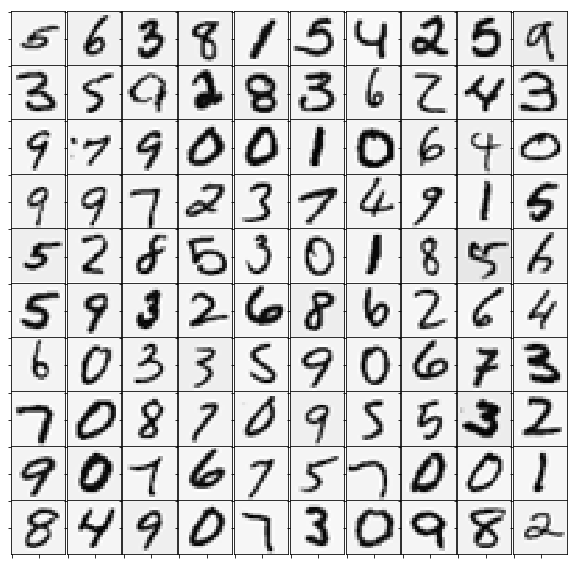

In [154]:
def displayData(X, nrows = 10, ncols = 10):
    
    # set up array
    fig, axarr = plt.subplots(nrows = nrows, ncols=ncols,
                              figsize=(nrows,ncols))
    
    # loop over randomly drawn numbers
    for ii in range(nrows):
        for jj in range(ncols):
            ind = np.random.randint(X.shape[0])
            tmp = X[ind, :].reshape(20, 20, order = 'F')
            axarr[ii, jj].imshow(tmp, cmap = 'gray_r')
            plt.setp(axarr[ii, jj].get_xticklabels(), visible = False)
            plt.setp(axarr[ii, jj].get_yticklabels(), visible = False)
    
    fig.subplots_adjust(hspace = 0, wspace=0)
displayData(X)    

### Reshaping Utilities

Some utility functions. There are lot of flattening and
reshaping of theta matrices, the input X matrix, etc...
Nicely shaped matrices make the linear algebra easier when developing,
but the minimization routine requires that all inputs

In [155]:


def flattenParams(thetas_list):
    # will flatten a theta array  into one long (n,1) shaped numpy array
    
    flattened_list = [ mytheta.flatten() for mytheta in thetas_list ]
    combined = list(itertools.chain.from_iterable(flattened_list))
    assert len(combined) == (input_layer_size + 1) * hidden_layer_size + \
                            (hidden_layer_size + 1) * output_layer_size
    return np.array(combined).reshape((len(combined), 1))

def reshapeParams(flattened_array):
    theta1 = flattened_array[:(input_layer_size + 1) * hidden_layer_size] \
            .reshape((hidden_layer_size,input_layer_size + 1))
        
    theta2 = flattened_array[(input_layer_size + 1) * hidden_layer_size:] \
            .reshape((output_layer_size,hidden_layer_size + 1))
    
    return [theta1,theta2]

def flattenX(X):
    return np.array(X.flatten()).reshape((n_training_samples * (input_layer_size + 1),1))

def reshapeX(flattenedX):
    return np.array(flattenedX).reshape((n_training_samples,input_layer_size + 1))

### Neural Networks - Feed Forward and Cost Function including regularisation

the Neural Network will have 3 layers, a hidden layers adn and ouput layer. The inputs are pixel valuesof digit images. The images are 20 x 20, this gives 400 inputs layers, 401 including the bias unit


Input layer size = 400 (20 x 20 pixels) <br>
Hidden layer size = 25<br>
Number of labels or output layers = 10<br>

the values of each of the activation nodes ias as follows <br>
$$a_1^{(2)} = g(\Theta_{10}^{(1)}x_0 + \Theta_{11}^{(1)}x_1 + \Theta_{12}^{(1)}x_2 + \Theta_{13}^{(1)}x_3) \Rightarrow a_1^{(2)} = g(z_1^{(2)})$$<br>
$$a_2^{(2)} = g(\Theta_{20}^{(1)}x_0 + \Theta_{21}^{(1)}x_1 + \Theta_{22}^{(1)}x_2 + \Theta_{23}^{(1)}x_3) \Rightarrow a_2^{(2)} = g(z_2^{(2)})$$<br>
$$a_3^{(2)} = g(\Theta_{30}^{(1)}x_0 + \Theta_{31}^{(1)}x_1 + \Theta_{32}^{(1)}x_2 + \Theta_{33}^{(1)}x_3) \Rightarrow a_3^{(2)} = g(z_3^{(2)})$$<br>
$$h_{\Theta}(x) = g(\Theta_{10}^{(2)}a_0 + \Theta_{11}^{(2)}a_1 + \Theta_{12}^{(1)}a_2. +\Theta_{13}^{(1)}a_3) = g(z^{(3)}) $$<br>

in vectorisation mode for settings $x = a^{(i)}$ we can write 
$$z^{(j)} = \Theta^{(j-1)}a^{(j-1)}$$

Vectorised implemetations of Forward Propogation:
$$a^{(1)} = x$$<br>
$$z^{(2)} = \Theta^{(1)} a^{(1)}$$<br>
$$a^{2} = g(z^{(2)}).... add... a_0^{(2)} = 1)$$<br>
$$z^{(3)} = \Theta^{(2)}a^{(2)}$$<br>
$$h_{\Theta}(x) = a^{(3)}  = g(z^{(3)})$$<br>


Sigmoid gradient
$$g′(z)=g(z)(1−g(z))$$

where
$$g(z)=\frac{1}{1+e^{-z}}$$


Cost Function 
$$ J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\big[y^{(i)}_{k} log(( h_\theta(x^{(i)}))_k)-(1-y^{(i)}_k)log(1-h_\theta(x^{(i)}))_k)\big]$$

Vectorised Cost Junction
$$ $$

In [156]:
# Input layer size = 400 (20x20 pixels)
# Hidden layer size = 25
# Number of labels = 10
# Neural Networks - Feed Forward and Cost Function

# Add intercept
X = np.c_[np.ones((data['X'].shape[0], 1)), data['X']]

input_layer_size = 400
hidden_layer_size = 25
output_layer_size = 10 
n_training_samples = X.shape[0]

In [157]:
def sigmoid(z):
    return(1 / (1 + np.exp(-z)))

def sigmoidGradient(z):
    return(sigmoid(z) * (1 - sigmoid(z)))

def computeCost(thetas_flattened, X_flattened, y, Reg = 0):
    """
    This function takes in:
        1) a flattened vector of theta parameters (each theta would go from one
           NN layer to the next), the thetas include the bias unit.
        2) the flattened training set matrix X, which contains the bias unit first column
        3) the label vector y, which has one column
    It loops over training points (recommended by the professor, as the linear
    algebra version is "quite complicated") and:
        1) constructs a new "y" vector, with 10 rows and 1 column, 
            with one non-zero entry corresponding to that iteration
        2) computes the cost given that y- vector and that training point
        3) accumulates all of the costs
        4) computes a regularization term (after the loop over training points)
    """
    
    # First unroll the parameters
    thetas = reshapeParams(thetas_flattened)
    
    # Now unroll X
    X = reshapeX(X_flattened)
    
    #This is what will accumulate the total cost
    total_cost = 0
    
    m = n_training_samples

    # Loop over the training points (rows in myX, already contain bias unit)
    for irow in range(m):
        row = X[irow]
                
        # First compute the hypothesis (this is a (10,1) vector
        # of the hypothesis for each possible y-value)
        # propagateForward returns (zs, activations) for each layer
        # so propagateforward[-1][1] means "activation for -1st (last) layer"
        h = propagateForward(row,thetas)[-1][1]

        # Construct a 10x1 "y" vector with all zeros and only one "1" entry
        # note here if the hand-written digit is "0", then that corresponds
        # to a y- vector with 1 in the 10th spot (different from what the
        # homework suggests)
        tmpy  = np.zeros((10,1))
        tmpy[y[irow]-1] = 1
        
        # Compute the cost for this point and y-vector
        cost = -tmpy.T.dot(np.log(h)) - (1 - tmpy.T).dot(np.log(1 - h))
     
        # Accumulate the total cost
        total_cost += cost
  
    # Normalize the total_cost, cast as float
    total_cost = float(total_cost) / m
    
    # Compute the regularization term
    total_reg = 0.
    for theta in thetas:
        total_reg += np.sum(theta * theta) #element-wise multiplication
        
    total_reg *= float(Reg)/(2 * m)
    Cost_Function = total_cost + total_reg
    
    return(Cost_Function)
       

def propagateForward(row,Thetas):
    """
    Function that given a list of Thetas (NOT flattened), propagates the
    row of features forwards, assuming the features ALREADY
    include the bias unit in the input layer, and the 
    Thetas also include the bias unit

    The output is a vector with element [0] for the hidden layer,
    and element [1] for the output layer
        -- Each element is a tuple of (zs, as)
        -- where "zs" and "as" have shape (# of units in that layer, 1)
    
    ***The 'activations' are the same as "h", but this works for many layers
    (hence a vector of thetas, not just one theta)
    Also, "h" is vectorized to do all rows at once...
    this function takes in one row at a time***
    """
   
    features = row
    zs_as_per_layer = []
    for i in range(len(Thetas)):  
        Theta = Thetas[i]
        #Theta is (25,401), features are (401, 1)
        #so "z" comes out to be (25, 1)
        #this is one "z" value for each unit in the hidden layer
        #not counting the bias unit
        z = Theta.dot(features).reshape((Theta.shape[0], 1))
        a = expit(z)
        zs_as_per_layer.append( (z, a) )
        if i == len(Thetas) - 1:
            return np.array(zs_as_per_layer)
        a = np.insert(a, 0, 1) #Add the bias unit
        features = a



#Once you are done, using the loaded set of parameters Theta1 and Theta2,
#you should see that the cost is about 0.287629
Thetas = [ theta1, theta2 ]

#Note I flatten the thetas vector before handing it to the computeCost routine,
#as per the input format of the computeCost function.
#It does the unrolling/reshaping itself
#I also flatten the X vector, similarly
Cost_Function = computeCost(flattenParams(myThetas),flattenX(X),y)

print('Total Cost Function: %.3f'%(Cost_Function))


Total Cost Function: 0.288


### Backpropagation

In [169]:
def sigmoidGradient(z):
    dummy = expit(z)
    return dummy*(1-dummy)

def genRandThetas():
    epsilon_init = 0.12
    theta1_shape = (hidden_layer_size, input_layer_size+1)
    theta2_shape = (output_layer_size, hidden_layer_size+1)
    rand_thetas = [ np.random.rand( *theta1_shape ) * 2 * epsilon_init - epsilon_init, \
                    np.random.rand( *theta2_shape ) * 2 * epsilon_init - epsilon_init]
    return rand_thetas

def backPropagate(thetas_flat,X_flat,y, Reg=0.):
    
    # First unroll the parameters
    thetas = reshapeParams(thetas_flat)
    
    # Now unroll X
    X = reshapeX(X_flat)

    #Note: the Delta matrices should include the bias unit
    #The Delta matrices have the same shape as the theta matrices
    Delta1 = np.zeros((hidden_layer_size, input_layer_size + 1))
    Delta2 = np.zeros((output_layer_size, hidden_layer_size + 1))

    # Loop over the training points (rows in myX, already contain bias unit)
    m = n_training_samples
    for irow in range(m):
        row = X[irow]
        a1 = row.reshape((input_layer_size+1,1))
        # propagateForward returns (zs, activations) for each layer excluding the input layer
        temp = propagateForward(row, thetas)
        
        z2 = temp[0][0]
        a2 = temp[0][1]
        z3 = temp[1][0]
        a3 = temp[1][1]
        
        tmpy = np.zeros((10,1))
        tmpy[y[irow] - 1] = 1
        
        delta3 = a3 - tmpy 
        delta2 = thetas[1].T[1:,:].dot(delta3) * sigmoidGradient(z2) #remove 0th element
        
        a2 = np.insert(a2,0,1,axis = 0)
        
        Delta1 += delta2.dot(a1.T) #(25,1)x(1,401) = (25,401) (correct)
        Delta2 += delta3.dot(a2.T) #(10,1)x(1,25) = (10,25) (should be 10,26)
        
    D1 = Delta1/float(m)
    D2 = Delta2/float(m)
    
    #Regularization:
    D1[:,1:] = D1[:,1:] + (float(Reg)/m) * thetas[0][:,1:]
    D2[:,1:] = D2[:,1:] + (float(Reg)/m) * thetas[1][:,1:]
    
    return flattenParams([D1, D2]).flatten()


#Actually compute D matrices for the Thetas provided
flatD1D2 = backPropagate(flattenParams(Thetas), flattenX(X), y, Reg = 0.)
D1, D2 = reshapeParams(flatD1D2)



### Gradient Checking

In [170]:
def checkGradient(thetas,Ds,X,y,Reg=0.):
    eps = 0.0001
    flat = flattenParams(thetas)
    flatDs = flattenParams(Ds)
    X_flat = flattenX(X)
    n_elems = len(flat) 
    #Pick ten random elements, compute numerical gradient, compare to respective D's
    for i in range(10):
        x = int(np.random.rand() * n_elems)
        epsvec = np.zeros((n_elems,1))
        epsvec[x] = eps
        cost_high = computeCost(flat + epsvec, X_flat, y, Reg)
        cost_low  = computeCost(flat - epsvec, X_flat, y, Reg)
        grad = (cost_high - cost_low) / float(2 * eps)
        print("Element: %d. Numerical Gradient = %f. BackProp Gradient = %f."%(x, grad,flatDs[x]))
        
checkGradient(Thetas,[D1, D2],X,y)

Element: 276. Numerical Gradient = 0.000115. BackProp Gradient = 0.000115.
Element: 9887. Numerical Gradient = 0.000043. BackProp Gradient = 0.000043.
Element: 4064. Numerical Gradient = 0.000084. BackProp Gradient = 0.000084.
Element: 8586. Numerical Gradient = -0.000137. BackProp Gradient = -0.000137.
Element: 8060. Numerical Gradient = -0.000000. BackProp Gradient = -0.000000.
Element: 4782. Numerical Gradient = -0.000016. BackProp Gradient = -0.000016.
Element: 1430. Numerical Gradient = 0.000059. BackProp Gradient = 0.000059.
Element: 4163. Numerical Gradient = -0.000175. BackProp Gradient = -0.000175.
Element: 5000. Numerical Gradient = 0.000272. BackProp Gradient = 0.000272.
Element: 160. Numerical Gradient = -0.000016. BackProp Gradient = -0.000016.


### Learning Parameters

In [171]:
def trainNN(Reg = 0):
    """
    Function that generates random initial theta matrices, optimizes them,
    and returns a list of two re-shaped theta matrices
    """

    randomThetas_unrolled = flattenParams(genRandThetas())
    result = scipy.optimize.fmin_cg(computeCost, x0 = randomThetas_unrolled, fprime = backPropagate, \
                               args = (flattenX(X),y,Reg),maxiter = 50, disp = True, full_output = True)
    return reshapeParams(result[0])
#Training the NN takes about ~70-80 seconds on my machine
learned_Thetas = trainNN()


         Current function value: 0.245995
         Iterations: 50
         Function evaluations: 112
         Gradient evaluations: 112


In [178]:
def predictNN(row,Thetas):
    """
    Function that takes a row of features, propagates them through the
    NN, and returns the predicted integer that was hand written
    """
    classes = range(1,10) + [10]
    output = propagateForward(row,Thetas)
    #-1 means last layer, 1 means "a" instead of "z"
    return classes[np.argmax(output[-1][1])] 

def computeAccuracy(X, Thetas,y):
    """
    Function that loops over all of the rows in X (all of the handwritten images)
    and predicts what digit is written given the thetas. Check if it's correct, and
    compute an efficiency.
    """
    n_correct, n_total = 0, X.shape[0]
    for irow in range(n_total):
        if int(predictNN(X[irow],Thetas)) == int(y[irow]): 
            n_correct += 1
    print("Training set accuracy: %0.1f%%"%(100*(float(n_correct)/n_total)))
    
computeAccuracy(X, learned_Thetas, y)
#Let's see if I set lambda to 10, if I get the same thing
learned_regularized_Thetas = trainNN(Reg = 10.)
computeAccuracy(X, learned_regularized_Thetas, y)

TypeError: unsupported operand type(s) for +: 'range' and 'list'